## This Notebook contains the implementation of the researcher SubGraph

This graph executes each step in the research plan by:
* Generating a list of queries based on the current step.
* Retrieving relevant documents in parallel for all queries.
* Returning the documents to the retrieval graph for response generation.

In [1]:
import os
from dotenv import  load_dotenv
load_dotenv()

True

In [2]:
!pwd

/Users/sumi/Desktop/skLearnF/Notebooks


In [3]:
os.chdir('../')
!pwd

/Users/sumi/Desktop/skLearnF


In [4]:
os.environ["GEMINI_API_KEY"] = os.getenv("GOOGLE_API_KEY")


In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm.invoke("Hi!")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-5dc843f7-4ab8-4332-ae3f-184bf8620d87-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

## 1. Define state schemas

In [6]:
from dataclasses import dataclass, field
from typing import Annotated, Any, Literal, Optional, Union
from langchain_core.documents import Document
import uuid
import hashlib

def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a document based on page content."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash))


def reduce_docs(
    existing: Optional[list[Document]],
    new: Union[
        list[Document],
        list[dict[str, Any]],
        list[str],
        str,
        Literal["delete"],
    ],
) -> list[Document]:
    """Reduce and process documents based on the input type.

    This function handles various input types and converts them into a sequence of Document objects.
    It can delete existing documents, create new ones from strings or dictionaries, or return the existing documents.
    It also combines existing documents with the new one based on the document ID.

    Args:
        existing (Optional[Sequence[Document]]): The existing docs in the state, if any.
        new (Union[Sequence[Document], Sequence[dict[str, Any]], Sequence[str], str, Literal["delete"]]):
            The new input to process. Can be a sequence of Documents, dictionaries, strings, a single string,
            or the literal "delete".
    """
    if new == "delete":
        return []

    existing_list = list(existing) if existing else []
    if isinstance(new, str):
        return existing_list + [
            Document(page_content=new, metadata={"uuid": _generate_uuid(new)})
        ]

    new_list = []
    if isinstance(new, list):
        existing_ids = set(doc.metadata.get("uuid") for doc in existing_list)
        for item in new:
            if isinstance(item, str):
                item_id = _generate_uuid(item)
                new_list.append(Document(page_content=item, metadata={"uuid": item_id}))
                existing_ids.add(item_id)

            elif isinstance(item, dict):
                metadata = item.get("metadata", {})
                item_id = metadata.get("uuid") or _generate_uuid(
                    item.get("page_content", "")
                )

                if item_id not in existing_ids:
                    new_list.append(
                        Document(**{**item, "metadata": {**metadata, "uuid": item_id}})
                    )
                    existing_ids.add(item_id)

            elif isinstance(item, Document):
                item_id = item.metadata.get("uuid", "")
                if not item_id:
                    item_id = _generate_uuid(item.page_content)
                    new_item = item.copy(deep=True)
                    new_item.metadata["uuid"] = item_id
                else:
                    new_item = item

                if item_id not in existing_ids:
                    new_list.append(new_item)
                    existing_ids.add(item_id)

    return existing_list + new_list

In [7]:

@dataclass(kw_only=True)
class QueryState:
    "Private state for the retrieve_documents node in the researcher graph"
    query: str
    
  
@dataclass(kw_only=True)
class ResearcherState:
    "State of the researcher graph"
    question: str
    queries: list[str]= field(default_factory=list) 
    documents: Annotated[list[Document], reduce_docs]=field(default_factory=list)
    
 


In [8]:
# Prompt for Researcher Graph
GENERATE_QUERIES_SYSTEM_PROMPT = """\
Generate 3 search queries to search for to answer the user's question. \
These search queries should be diverse in nature - do not generate \
repetitive ones."""

In [9]:
from langchain_core.documents import Document
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from typing import TypedDict, cast


# Genrate queries node
async def generate_queries(
    state: ResearcherState, *, config: RunnableConfig
    )-> dict[str, list[str]]:
    """Generate search queries based on the question (a step in the research plan)."""
    
    class Response(TypedDict):
        queries: list[str]
        
    model=llm.with_structured_output(Response)
    messages=[
        {"role": "system", "content": GENERATE_QUERIES_SYSTEM_PROMPT},
        {"role": "human", "content": state.question},
    ]
    response= cast(Response, await model.ainvoke(messages))
    return {"queries": response["queries"]}


    

## 2. Create retriever

In [10]:
from langchain_chroma import Chroma

# Load the persisted directory
db = Chroma(persist_directory="DATA/chroma_store",
            embedding_function=embeddings)

# Convert it into a retriever
retriever = db.as_retriever()



In [11]:
import os
print(os.listdir("DATA/chroma_store"))


['f8dfb7fb-0254-4ad6-a5d7-21c437379a58', 'chroma.sqlite3']


In [12]:
print(db._collection.count())  # Should return number of vectors stored


28507


In [13]:
retriever.invoke("what is classification?")

[Document(id='05c689e2-53f0-4df1-bc83-478fe9525710', metadata={'description': 'Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the val...', 'language': 'en', 'source': 'https://scikit-learn.org/stable/modules/naive_bayes.html', 'title': '1.9. Naive Bayes — scikit-learn 1.6.1 documentation'}, page_content='\\[P(x_i | y, x_1, \\dots, x_{i-1}, x_{i+1}, \\dots, x_n) = P(x_i | y),\\]\nfor all \\(i\\), this relationship is simplified to\n\n\\[P(y \\mid x_1, \\dots, x_n) = \\frac{P(y) \\prod_{i=1}^{n} P(x_i \\mid y)}\n                                 {P(x_1, \\dots, x_n)}\\]\nSince \\(P(x_1, \\dots, x_n)\\) is constant given the input,\nwe can use the following classification rule:'),
 Document(id='728e1625-25e3-4cdd-a952-f187d37eb79b', metadata={'description': 'Ensemble methods combine the predictions of several base estimators built with a given learn

In [14]:
print("Number of documents in vectorstore:", len(db.get()["documents"]))


Number of documents in vectorstore: 28507


In [15]:
# retrieve documents node
async def retrieve_documents(
    state: QueryState, *, config: RunnableConfig
    )-> dict[str, list[Document]]:
    """Retrieve documents based on a given query."""
    
    response=await retriever.ainvoke(state.query,config)
    return {"documents": response}

In [16]:
# retrieve documents in parallel
def retrieve_in_parallel(state: ResearcherState)-> list[Send]:
    """Create parallel retrieval tasks for each generated query."""
    return [
        Send("retrieve_documents", QueryState(query=query)) for query in state.queries
    ]

## 3. Graph definition

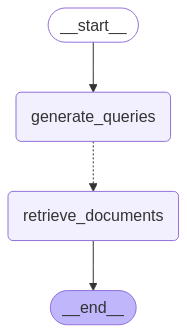

In [17]:
builder = StateGraph(ResearcherState)
builder.add_node(generate_queries)
builder.add_node(retrieve_documents)
builder.add_edge(START, "generate_queries")
builder.add_conditional_edges(
    "generate_queries",
    retrieve_in_parallel,  # type: ignore
    path_map=["retrieve_documents"],
)
builder.add_edge("retrieve_documents", END)
# Compile into a graph object that you can invoke and deploy.
graph = builder.compile()
graph.name = "ResearcherGraph"
graph

In [20]:
import asyncio

state = ResearcherState(question="How to perform PCA on images?")
final_state = await graph.ainvoke(state)


/Users/sumi/miniforge3/envs/CDEnv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(
/var/folders/vm/62zyvxyx70qb5rrghd3vfnx80000gn/T/ipykernel_49528/3679931618.py:69: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  new_item = item.copy(deep=True)


In [21]:
final_state

{'question': 'How to perform PCA on images?',
 'queries': ['PCA for image dimensionality reduction',
  'image PCA implementation python',
  'principal component analysis image processing'],
 'documents': [Document(id='429140ec-8400-4b91-b78c-02deebac1e5f', metadata={'description': 'The dataset used in this example is a preprocessed excerpt of the “Labeled Faces in the Wild”, aka LFW: http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz(233MB) Download the data, if not already on ...', 'language': 'en', 'source': 'https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html', 'title': 'Faces recognition example using eigenfaces and SVMs — scikit-learn 1.6.1 documentation', 'uuid': '27390807-319c-2189-5dc8-90e18e9d0878'}, page_content='Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled\ndataset): unsupervised feature extraction / dimensionality reduction\nn_components = 150\n\nprint(\n    "Extracting the top %d eigenfaces from %d faces" % (n_compone